In [85]:
#import libraries
import numpy as np
from ase.io import read, write
from ase import Atoms
import torch
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs('img_res', exist_ok=True) #creates a folder to store the loss graphs

In [86]:
#importing the full data (this is in case I have like the whole data in one file)
db = read('251017_training_data.xyz', ':')

In [87]:
#splitting the data into the training and test sets
write('train_01.xyz', db[:520])
write('test_01.xyz', db[520:])

In [88]:
#setting the model name based on model number and epochs
''' model_num:
    1 -> this indicates the model using 250 training data
    2 -> this indicates the model using 520 training data which is 80% of the data set '''
model_num = 2
''' num_epochs:
    sets the number of epochs used for running the trainig'''
num_epoch = 5
''' model_name:
    generates the name of the model based on the number of epochs and the model number using the 'model_num' variable '''
model_name = f'model_0{model_num}_{num_epoch}epochs'
model_name

'model_02_5epochs'

In [89]:
#this writes the yml file
config = {
    "model": "MACE",
    "num_channels": 32,
    "max_L": 0,
    "r_max": 4.0,
    "name": model_name,
    "train_file": f"train_01.xyz",
    "valid_fraction": 0.01,
    "test_file": f"test_01.xyz",
    "energy_key": "energy",
    "forces_key": "forces",
    "batch_size": 32,
    "max_num_epochs": num_epoch,
    "device": "cuda",
    "seed": 123
}
with open("config_new_model.yml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

In [90]:
#Perform training
import warnings
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

#defining the training function
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ['program', '--config', config_file_path]
    mace_run_train_main()

#calling the function
train_mace('config_new_model.yml') #aca va el nombre del yml file 

2025-10-22 16:41:30.273 INFO: ===========VERIFYING SETTINGS===========
2025-10-22 16:41:30.274 INFO: MACE version: 0.3.14
2025-10-22 16:41:30.275 INFO: CUDA version: 12.6, CUDA device: 0
2025-10-22 16:41:30.609 INFO: ===========LOADING INPUT DATA===========
2025-10-22 16:41:30.609 INFO: Using heads: ['Default']
2025-10-22 16:41:30.609 INFO: Using the key specifications to parse data:
2025-10-22 16:41:30.609 INFO: Default: KeySpecification(info_keys={'energy': 'energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'forces', 'charges': 'REF_charges'})
2025-10-22 16:41:30.609 INFO: =============    Processing head Default     ===========
2025-10-22 16:41:30.789 WARNING: Since ASE version 3.23.0b1, using energy_key 'energy' is no longer safe when communicating between MACE and ASE. We recommend using a dif

In [91]:
#reading the information on the results file
results = f'results/{model_name}_run-123_train.txt' #reading the file where the training results is stored
data = [] #where the data from the 'results' file will be stored
with open(results, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

In [92]:
#saving the data in a dataframe to be able to work with it in an easier way
df = pd.DataFrame(data)
#separating the training and validation results
train_df = df[df['mode']=='opt'].copy()
val_df = df[df['mode']=='eval'].copy().dropna()
train_df = train_df.groupby('epoch', as_index=False)['loss'].last()
#here we take the na values of the epocs that might appear by using the ffill function which fills the na values by propagating the last vaid observation to next valid 
#train_df['epoch'] = train_df['epoch'].ffill()
#val_df['epoch'] = val_df['epoch'].ffill()

In [93]:
train_df

,epoch,loss
0,0.0,120.034388
1,1.0,189.677558
2,2.0,270423.463248
3,3.0,221.368493
4,4.0,567.938540


In [94]:
val_df

,loss,mae_e,mae_e_per_atom,rmse_e,rmse_e_per_atom,q95_e,mae_f,rel_mae_f,rmse_f,rel_rmse_f,q95_f,time,mode,epoch,head
17,30.902569,52.243349,4.779396,57.773976,4.945626,89.112909,0.861404,98.639147,1.140411,89.767846,2.311635,0.034177,eval,0.0,Default
34,15.532373,46.365031,4.282608,50.348968,4.406562,75.511333,0.542064,62.071655,0.763178,60.073847,1.412091,0.034265,eval,1.0,Default
51,14.385469,41.268122,3.852340,44.363367,3.980189,65.248380,0.529378,60.618891,0.748902,58.950111,1.346157,0.037669,eval,2.0,Default
68,16.313447,35.257703,3.338644,37.679112,3.500605,54.028059,0.562836,64.450246,0.832544,65.534034,1.498400,0.028193,eval,3.0,Default
85,11.478450,33.797128,3.176782,36.519618,3.333598,54.057869,0.471038,53.938430,0.680289,53.549237,1.199602,0.031917,eval,4.0,Default
97,27.564549,53.830698,4.926505,59.636599,5.108657,92.333670,0.763330,87.408678,1.056998,83.201954,2.324906,0.032105,eval,0.0,Default
108,25.498705,51.164454,4.677742,56.579047,4.836861,87.207498,0.763673,87.447965,1.020286,80.312174,1.881122,0.033408,eval,1.0,Default
119,15.508611,47.100206,4.344843,51.249065,4.472351,77.042067,0.537592,61.559566,0.758559,59.710232,1.551990,0.033371,eval,2.0,Default
130,15.019444,43.792981,4.056432,47.391109,4.175539,70.534699,0.555188,63.574468,0.759356,59.772960,1.271291,0.032995,eval,3.0,Default
141,12.481355,39.290804,3.670264,42.224172,3.794654,62.004517,0.470009,53.820553,0.692874,54.539798,1.067431,0.034069,eval,4.0,Default


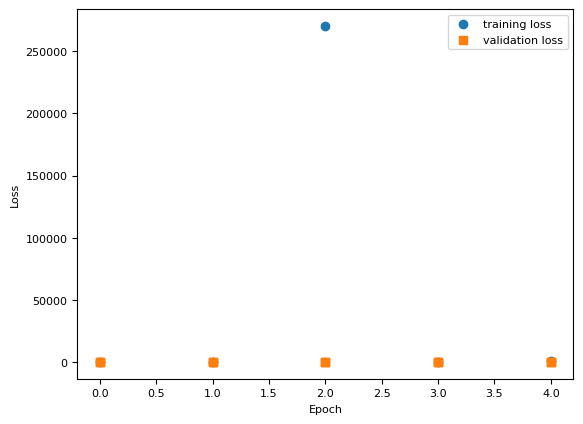

In [95]:
#plotting the 
#plt.figure()
plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

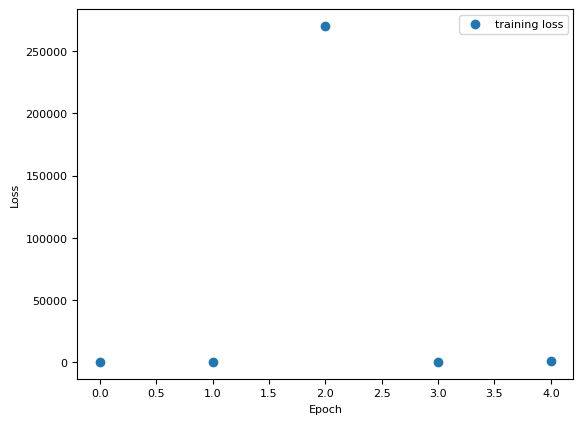

In [ ]:
#plt.figure()
plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
#plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#saving the plots
last_epoch = int(train_df['epoch'].max())
filename = f'img_res/{model_name}_train_loss.pdf'
#filename = f'img_res/{model_name}_train_loss_batch50.pdf'
plt.savefig(filename)

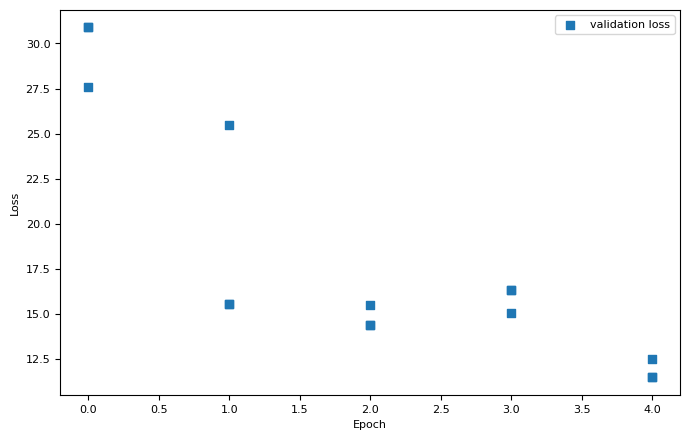

In [97]:
plt.figure(figsize=(8,5))
#plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#saving the plots
last_epoch = int(train_df['epoch'].max())
#filename = f'img_res/{model_name}_val_loss.pdf'
filename = f'img_res/{model_name}_val_loss_batch50.pdf'
plt.savefig(filename)

In [98]:
#this is commented for now because we have set the data on which the energy and forces will be calculated
'''#once the training is done, then a calculation can be performed using ase
from ase.io import read
from mace.calculators import MACECalculator

#loading the model
calculator = MACECalculator(model_paths=f'{model_name}.model', device='cuda')
#read the configurations from where we want to calculate
### I set here the training data, but we could also calculate it on different data to see how it actually performs on new data
configs = read('test_01.xyz', ':')

#set a list to store the information
results = []
# read the results
for i, atoms in enumerate(configs):
    atoms.set_calculator(calculator)
    energy = atoms.get_potential_energy()
    forces = atoms.get_forces()
    #max_force = abs(forces).max()  # max absolute force
    #mean_force = abs(forces).mean()  # mean absolute force
    # Add to list
    results.append({
        "config_id": i,
        "energy (eV)": energy,
    #    "max_force (eV/Å)": max_force,
    #    "mean_force (eV/Å)": mean_force,
        "num_atoms": len(atoms)
    })
# Create dataframe
df = pd.DataFrame(results)
df.to_excel(f'{model_name}.xlsx', index=False) #this is to save the results in an exel file'''

'#once the training is done, then a calculation can be performed using ase\nfrom ase.io import read\nfrom mace.calculators import MACECalculator\n\n#loading the model\ncalculator = MACECalculator(model_paths=f\'{model_name}.model\', device=\'cuda\')\n#read the configurations from where we want to calculate\n### I set here the training data, but we could also calculate it on different data to see how it actually performs on new data\nconfigs = read(\'test_01.xyz\', \':\')\n\n#set a list to store the information\nresults = []\n# read the results\nfor i, atoms in enumerate(configs):\n    atoms.set_calculator(calculator)\n    energy = atoms.get_potential_energy()\n    forces = atoms.get_forces()\n    #max_force = abs(forces).max()  # max absolute force\n    #mean_force = abs(forces).mean()  # mean absolute force\n    # Add to list\n    results.append({\n        "config_id": i,\n        "energy (eV)": energy,\n    #    "max_force (eV/Å)": max_force,\n    #    "mean_force (eV/Å)": mean_force